In [1]:
import pandas as pd
import boto3
import numpy as np
from collections import Counter
import os
import awswrangler as wr
import random
from datetime import datetime
import re, string
from typing import Dict

import torch, torchtext
import torchvision.models as models
from torchtext.data.utils import get_tokenizer
from torch.utils.data import TensorDataset, DataLoader
from torchtext.vocab import GloVe
from torch import nn, optim
from torch.nn import Module, Embedding, LSTM, RNN, GRU, Linear, Sequential, Dropout
from torch.nn.functional import sigmoid, relu, elu, tanh
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.nn.utils.rnn import PackedSequence

from utils import save_to_s3, get_from_s3
from quality_calculator import compute_bias_metrics_for_model, calculate_overall_auc, get_final_metric


from tqdm import tqdm

SEED = 1234
N_SAMPLES = 100_000

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

import time

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Today I'm going to use {device.type}")

Today I'm going to use cuda


In [4]:
TODAY = datetime.today().strftime("%Y%m%d")
BUCKET_NAME = 'sagemaker-godeltech'
TRAIN_PATH = f"s3://{BUCKET_NAME}/data/train/train.csv"
VAL_PATH = f"s3://{BUCKET_NAME}/data/validate/validate.csv"
TEST_PATH = f"s3://{BUCKET_NAME}/data/test/test.csv"
VOCAB_PATH = "lstm/vocab"
MODEL_PATH = "lstm/models"
PATH_LOGS = 'loggings'

In [5]:
train = wr.s3.read_csv([TRAIN_PATH])
val = wr.s3.read_csv([VAL_PATH])
test = wr.s3.read_csv([TEST_PATH])

In [6]:
train_sample = train.sample(N_SAMPLES, random_state=SEED, ignore_index=True)
val_sample = val.sample(N_SAMPLES, random_state=SEED, ignore_index=True)
train.shape, val.shape, test.shape

((1443900, 2), (360975, 2), (194641, 12))

In [7]:
train_text = train_sample['comment_text']
val_text = val_sample['comment_text']
train_label = train_sample['toxicity']
val_label = val_sample['toxicity']
test_text = test['comment_text']

In [8]:
# train_text, val_text, test_text = train_sample['comment_text'], val_sample['comment_text'], test['comment_text']
# train_label, val_label, test_label = train_sample['toxicity'], val_sample['toxicity'], test['toxicity']
train_text, val_text, test_text = train['comment_text'], val['comment_text'], test['comment_text']
train_label, val_label, test_label = train['toxicity'], val['toxicity'], test['toxicity']

train_label = torch.tensor(train_label.values, dtype=torch.float32).to(device)
val_label = torch.tensor(val_label.values, dtype=torch.float32).to(device) 
test_label = torch.tensor(test_label.values, dtype=torch.float32).to(device) 

In [9]:
tokenizer = get_tokenizer("basic_english")
counter = Counter()
for line in train_text:
    counter.update(tokenizer(line))
    
# Create a vocabulary with words seen at least 3 (min_freq) times
vocab = torchtext.vocab.vocab(counter, min_freq=3)

In [10]:
# Add the unknown token and use it by default for unknown words
unk_token = '<unk>'
# vocab.insert_token(unk_token, 0)
vocab.set_default_index(0)

# Add the pad token Explanation https://huggingface.co/docs/transformers/pad_truncation
pad_token = '<pad>'
vocab.insert_token(pad_token, 1)

In [11]:
text_transform_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

In [16]:
#save vocab
torch.save(vocab, f'../tmp/vocab_obj_{TODAY}.pth')
save_to_s3(BUCKET_NAME, f'../tmp/vocab_obj_{TODAY}.pth', f"{VOCAB_PATH}/vocab_obj_{TODAY}.pth")

In [17]:
print(f"Before transform:\n{train_text.iloc[1666]}")
print(f"After transform:\n{text_transform_pipeline(train_text.iloc[1666])}")

Before transform:
Obviously is there on plain sky and the agenda behind pretty dark a big name for all science   "   Geoengineering   "  
After transform:
[2835, 97, 141, 243, 5085, 5987, 49, 59, 839, 169, 1090, 2143, 42, 268, 962, 29, 170, 579, 10742]


In [18]:
def transformText(text_list, max_len):
    # Transform the text
    transformed_data = [text_transform_pipeline(text)[:max_len] for text in text_list]

    # Pad zeros if the text is shoter than max_len
    for data in transformed_data:
        data[len(data) : max_len] = np.ones(max_len - len(data))

    return torch.tensor(transformed_data, dtype=torch.int64)

In [19]:
#PARAMETERS
N_EPOCHES = 10
max_len = 100
batch_size = 128

# Size of the state vectors
lstm_hiden_size = 128
dense_hiden_size = 4 * lstm_hiden_size

# General NN training parameters
learning_rate = 0.0001

In [20]:
# Create data loaders
train_dataset = TensorDataset(
    transformText(train_text, max_len), train_label
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = TensorDataset(transformText(val_text, max_len), val_label)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TensorDataset(transformText(test_text, max_len), test_label)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/tmp/ipykernel_18497/3562846554.py:9: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(transformed_data, dtype=torch.int64)


In [21]:
#Pretrained Word Embeddings ====> GloVe, FastText, CharNGram
#Let us try GloVe

glove = GloVe(name="6B", dim=300)
embedding_matrix = glove.get_vecs_by_tokens(vocab.get_itos())

.vector_cache/glove.6B.zip: 862MB [02:47, 5.14MB/s]                               
100%|█████████▉| 399999/400000 [00:29<00:00, 13592.31it/s]


In [22]:
embedding_matrix.shape

torch.Size([102642, 300])

In [23]:
# Embedding vector and vocabulary sizes
embed_size = 300  # glove.6B.300d.txt
vocab_size = len(vocab.get_itos())
vocab_size

102642

In [24]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, lstm_hiden_size, dense_hiden_size):
        super(NeuralNet, self).__init__()
        max_features = embedding_matrix.shape[0]
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(embedding_matrix.clone().detach())
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.666)

        self.lstm1 = nn.LSTM(embed_size, lstm_hiden_size, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hiden_size * 2, lstm_hiden_size, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(dense_hiden_size, dense_hiden_size)
        self.linear2 = nn.Linear(dense_hiden_size, dense_hiden_size)
        
        self.linear_out = nn.Linear(dense_hiden_size, 1)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = relu(self.linear1(h_conc))
        h_conc_linear2  = relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2       
        result = self.linear_out(hidden)

        return result

In [25]:
model = NeuralNet(embedding_matrix, lstm_hiden_size, dense_hiden_size)
# Setting our trainer
trainer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# We will use Binary Cross-entropy loss
cross_ent_loss = nn.BCEWithLogitsLoss(reduction='mean')

In [26]:
train_losses = []
val_losses = []
train_scores = []
val_scores = []

# Get the compute device
model.to(device)

for epoch in range(N_EPOCHES):
    start = time.time()
    training_loss = 0
    val_loss = 0
    train_score = 0
    val_score = 0
    model.train()

    for data, target in tqdm(train_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = cross_ent_loss(output.squeeze(1), target)
        trainer.zero_grad()
        loss.backward()
        trainer.step()
        training_loss += loss.item()
        try:
            train_score += roc_auc_score(target.cpu(), output.detach().cpu().numpy())
        except ValueError:
            pass      
        
    model.eval()
    
    for data, target in tqdm(val_loader):
        data = data.to(device)
        target = target.to(device)
        val_predictions = torch.sigmoid(model(data)).squeeze(1)
        loss = cross_ent_loss(val_predictions, target)
        val_loss += loss.item()
        try:
            val_score += roc_auc_score(target.cpu(), val_predictions.detach().cpu().numpy())
        except ValueError:
            pass
        
        
    # Let's take the average losses
    training_loss = training_loss / len(train_label)
    val_loss = val_loss / len(val_label)
    train_score = train_score / len(train_label)
    val_score = val_score / len(val_label)
    
    train_losses.append(training_loss)
    val_losses.append(val_loss)
    train_scores.append(train_score)
    val_scores.append(val_score)

    end = time.time()
    print(
        f"Epoch {epoch}. Train_loss {training_loss}. Validation_loss {val_loss}. Seconds {end-start}"
    )

100%|██████████| 2821/2821 [00:27<00:00, 102.03it/s]


Epoch 0. Train_loss 0.0014650449600834142. Validation_loss 0.005579222143583908. Seconds 292.5038192272186


100%|██████████| 2821/2821 [00:27<00:00, 101.81it/s]


Epoch 1. Train_loss 0.0012603025105973097. Validation_loss 0.0056577433875346994. Seconds 290.5562837123871


100%|██████████| 2821/2821 [00:27<00:00, 102.02it/s]


Epoch 2. Train_loss 0.0012072019829114922. Validation_loss 0.005664832799898157. Seconds 290.57846999168396


100%|██████████| 2821/2821 [00:27<00:00, 101.85it/s]


Epoch 3. Train_loss 0.0011742246703713858. Validation_loss 0.005653549550898774. Seconds 291.1158661842346


100%|██████████| 2821/2821 [00:27<00:00, 100.80it/s]


Epoch 4. Train_loss 0.0011499171291095942. Validation_loss 0.005678097951923251. Seconds 290.7745010852814


100%|██████████| 2821/2821 [00:27<00:00, 101.93it/s]


Epoch 5. Train_loss 0.0011332279557726111. Validation_loss 0.005673812070095322. Seconds 290.6320757865906


100%|██████████| 2821/2821 [00:27<00:00, 101.98it/s]


Epoch 6. Train_loss 0.0011185805570194617. Validation_loss 0.005666182973277693. Seconds 290.8747990131378


100%|██████████| 2821/2821 [00:27<00:00, 101.77it/s]


Epoch 7. Train_loss 0.001105380109881226. Validation_loss 0.005656157590253291. Seconds 290.7187328338623


100%|██████████| 2821/2821 [00:27<00:00, 101.85it/s]


Epoch 8. Train_loss 0.0010958442859162261. Validation_loss 0.005641125519608054. Seconds 290.98095321655273


100%|██████████| 2821/2821 [00:28<00:00, 100.45it/s]

Epoch 9. Train_loss 0.0010857873547501541. Validation_loss 0.005653868196116102. Seconds 290.96274852752686


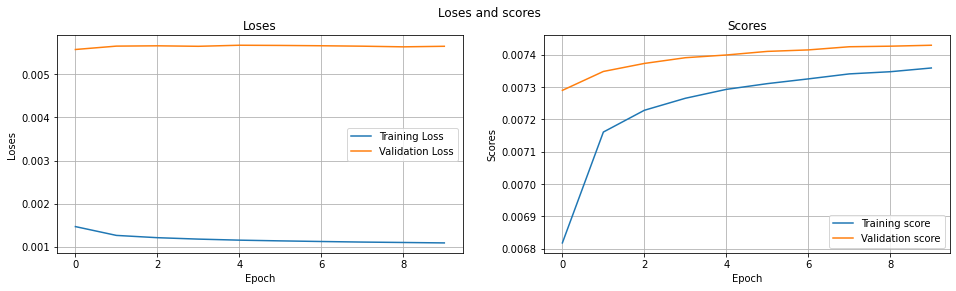

In [27]:
plt.rcParams['axes.grid'] = True

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('Loses and scores')
ax[0].plot(train_losses, label="Training Loss")
ax[0].plot(val_losses, label="Validation Loss")
ax[0].legend()
ax[0].set_title('Loses')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loses")
ax[1].plot(train_scores, label="Training score")
ax[1].plot(val_scores, label="Validation score")
ax[1].legend()
ax[1].set_title('Scores')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Scores")
plt.show()

In [28]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

model.eval()
test_predictions = []
for data, target in tqdm(test_loader):
    test_preds = model(data.to(device))
    test_predictions.extend(
        [sigmoid(test_pred[0]) for test_pred in test_preds.detach().cpu().numpy()]
    )

100%|██████████| 1521/1521 [00:14<00:00, 105.24it/s]


In [29]:
sum(test_predictions), len(test_predictions)
oof_name = 'predicted_target'
test[oof_name] = test_predictions

In [32]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save(f'../tmp/lstm_model_{TODAY}.pt') # Save
save_to_s3(BUCKET_NAME, f'../tmp/lstm_model_{TODAY}.pt', f"{MODEL_PATH}/lstm_model_{TODAY}.pt")

RuntimeError: Can't redefine method: forward on class: __torch__.SpatialDropout (of Python compilation unit at: 0x5649986361a0)

### TESTING

In [57]:
uploaded_vocab = torch.load(f'../tmp/vocab_obj_{TODAY}.pth')
uploaded_model = torch.jit.load(f'../tmp/lstm_model_{TODAY}.pt')
uploaded_model.eval()

In [123]:
test_strings = ["Any news on the prizes ? Monika Kaczmarek", "give us some more time🙌 We'll contact with you when it will be ready 🚀","Hello Viktoryia Charnianina, is it critical to send the invoice within the specified period (last day of month - 5th of the next month)? I've send my invoice a bit earlier.",
                "Hello everyone. Please tell me who I can contact about my vacation? I have some questions about Unused day off. Thanks.",
               "Hi everyone! Hope you had a great Tuesday! Is there anybody who sells iPhone 12/13? I broke mine yesterday ",
               "Do we have any kind of comparison between Komfort and Komfort plus plans?",
"What if somebody wants to stay on a Komfort plan further? Do they need to fill up a questionnaire?",
"Nope smile You do not need to do anything. It will be prolonged automatically. ",
"""Hi!
Have I understood correctly that 'Declaration' that is mentioned above is called as "Formularz - medical insurance" in Sharepoint?"""
"I have found the answer))))",
"General those who has Standard last year, you will be automatically moved to Komfort ( still it will be free of charge for you). If you do not want to have any package, this is the last moment for you to let me know. ",
"General some of you started to receive your PZU declarations. Please do not worry if you haven't received yours yet or if you have received one of them ( medical/life insurance) but haven't received the rest. You'll receive the remaining files next week. It's just to many declarations to deal with. Hope for your understanding",
"please mind couple of things when you send me scans of your documents: 1) I just need PZU Life Insurance scan; 2) You need to send 1st and 2nd page as one PDF file and send it to me  ( just picture of your signature has no value); 3) Even if you sent a scan, you still need to bring/mail us the oginal ( also original of medical insurance if you have one). In case you haven't received password to your files, it is: 2022 "]

In [124]:
text_transform_pipeline = lambda x: [uploaded_vocab[token] for token in tokenizer(x)]

def transformText(text_list, max_len):
    # Transform the text
    transformed_data = [text_transform_pipeline(text)[:max_len] for text in text_list]

    # Pad zeros if the text is shoter than max_len
    for data in transformed_data:
        data[len(data) : max_len] = np.ones(max_len - len(data))

    return torch.tensor(transformed_data, dtype=torch.int64)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def determine_toxicity(text):
    
    transformed = transformText([text], 100)
    test_loader = DataLoader(transformed, batch_size=batch_size)
    uploaded_model.eval()
    test_predictions = []
    for data in test_loader:
        test_preds = uploaded_model(data)
        test_predictions.extend(
            [sigmoid(test_pred[0]) for test_pred in test_preds.detach().cpu().numpy()]
        )
    return test_predictions[0]


In [126]:
for text in test_strings:
    print(f"{text}, toxicity = {determine_toxicity(text)}")

/tmp/ipykernel_100/3562846554.py:9: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(transformed_data, dtype=torch.int64)


Any news on the prizes ? Monika Kaczmarek, toxicity = 0.0026159089221749533
give us some more time🙌 We'll contact with you when it will be ready 🚀, toxicity = 0.011255433559864048
Hello Viktoryia Charnianina, is it critical to send the invoice within the specified period (last day of month - 5th of the next month)? I've send my invoice a bit earlier., toxicity = 0.0003022625042109019
Hello everyone. Please tell me who I can contact about my vacation? I have some questions about Unused day off. Thanks., toxicity = 0.0004920312795431989
Hi everyone! Hope you had a great Tuesday! Is there anybody who sells iPhone 12/13? I broke mine yesterday , toxicity = 0.0011299277615885526
Do we have any kind of comparison between Komfort and Komfort plus plans?, toxicity = 0.0019972811668783636
What if somebody wants to stay on a Komfort plan further? Do they need to fill up a questionnaire?, toxicity = 0.0012617091600208232
Nope smile You do not need to do anything. It will be prolonged automaticall

In [2]:
import logging
import boto3
from botocore.exceptions import ClientError
import os


def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = os.path.basename(file_name)

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [ ]:
bucket = 'godelsagemaker'

In [8]:
a = pd.DataFrame([True, True, False, True], columns=['the_values'])
a.the_values.astype('float32')

0    1.0
1    1.0
2    0.0
3    1.0
Name: the_values, dtype: float32